In [10]:
import torch 
import time
from utilities_DL import get_DataSet_and_invalid_dates,get_MultiModel_loss_args_emb_opts
from DL_class import MultiModelTrainer, Trainer
from config import get_args
from plotting import plot_k_fold_split
from save_results import update_results_df
from paths import folder_path,file_name,get_save_directory

import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Load config
model_name = 'STGCN' #'CNN'
args = get_args(model_name)
#args = get_args(model_name = model_name,learn_graph_structure = True)  # MTGNN

# Modification : 
args.epochs = 50
args.K_fold = 6
args.ray = False

# Save Directory:
save_dir = get_save_directory(args)

In [ ]:
model_param = torch.load(f"{save_dir}best_model_fold0.pkl")

### Load data and Model
**Bien load le dataset après avoir défini appelé args**

coverage period: 2019-01-01 00:00:00 - 2020-01-01 00:00:00
Time-step per hour: 4.0


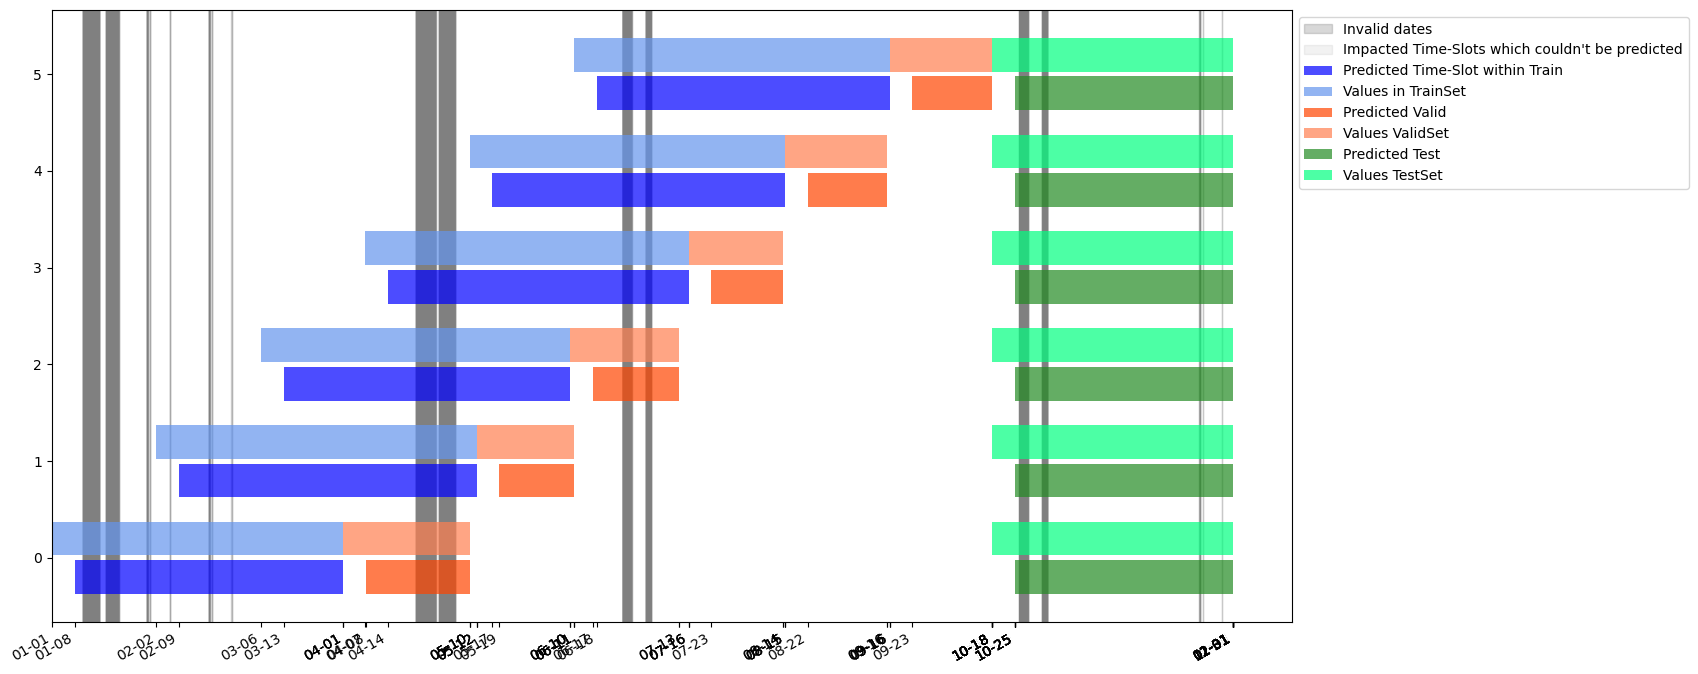

In [4]:
# Load DataSet, plot k_fold split:
dataset,invalid_dates = get_DataSet_and_invalid_dates(args.abs_path, folder_path,file_name,
                                                      args.W,args.D,args.H,args.step_ahead,
                                                      single_station = False)
(Datasets,DataLoader_list,time_slots_labels_list,dic_class2rpz_list,dic_rpz2class_list,nb_words_embedding_list) =  dataset.split_K_fold(args,invalid_dates)
plot_k_fold_split(Datasets,invalid_dates)

In [6]:
# Load empty model :
(loss_function,Model_list,Optimizer_list,Scheduler_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding_list,dic_class2rpz_list,n_vertex = len(Datasets[0].columns))
#(loss_function,Model_list,Optimizer_list,args_embedding) = get_MultiModel_loss_args_emb_opts(args,nb_words_embedding_list,dic_class2rpz_list)
#assert len(Model_list) == 1, "Il y a plus d'un seul model dans la liste, i.e K_fold > 1"

# Associate dict :
model = Model_list[0]
#model.load_state_dict(model_param['state_dict'])
data_loader = DataLoader_list[0]
optimizer = Optimizer_list[0]
dic_class2rpz = dic_class2rpz_list[0]

## Torch Compile / Torch.jit : 
Facilement des problème de version : 
- Torch compile necessite pytorch >2.x (2.0 ou 2.1), mais python <3.12)

In [ ]:
! python --version
torch.__version__

## Torch Script
visiblement problème...

In [33]:
class CausalConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, enable_padding=False, dilation=1, groups=1, bias=True):
        kernel_size = nn.modules.utils._pair(kernel_size)
        stride = nn.modules.utils._pair(stride)
        dilation = nn.modules.utils._pair(dilation)
        self.enable_padding = enable_padding
        self.papadding = [int((kernel_size[i] - 1) * dilation[i]) for i in range(len(kernel_size))] if enable_padding else 0#[0, 0]
        self.left_padding = nn.modules.utils._pair(self.papadding)
        super(CausalConv2d, self).__init__(in_channels, out_channels, kernel_size, stride=stride, padding=0, dilation=dilation, groups=groups, bias=bias)
        
    def forward(self, input):
        if self.enable_padding:#preferer une condition booleenne !!! self.papadding != 0:
            #print(f'input shape: {input.shape} \n Args F.pad: ({self.left_padding[1]}, 0, {self.left_padding[0]}, 0)')
            input = F.pad(input, (self.left_padding[1], 0, self.left_padding[0], 0))
        result = super(CausalConv2d, self).forward(input)

        return result

class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.layer = nn.Conv2d(kernel_size = (3,3),in_channels = 2, out_channels = 10)
        self.dense = nn.Linear(3,4)
        self.causal = CausalConv2d(in_channels = 2, 
                                    out_channels = 10,
                                    kernel_size = (3,3), 
                                    stride=1, enable_padding=False, dilation=1, groups=1, bias=True)

    def forward(self,x):
        p = self.causal(x)
        return(self.layer(self.dense(x)))

m1 = Model()
compiled_m1 = torch.jit.script(m1)


RuntimeError: 
Python type cannot be used as a value:
  File "C:\Users\romai\AppData\Local\Temp\ipykernel_29712\3944329744.py", line 15
            #print(f'input shape: {input.shape} \n Args F.pad: ({self.left_padding[1]}, 0, {self.left_padding[0]}, 0)')
            input = F.pad(input, (self.left_padding[1], 0, self.left_padding[0], 0))
        result = super(CausalConv2d, self).forward(input)
                       ~~~~~~~~~~~~ <--- HERE
    
        return result


## Torch Compile : 

In [12]:
# permet d'activer les log détaillés de dynamo. 
import torch._dynamo
torch._dynamo.config.suppress_errors = True 
# Le code fonctionne enfin, mais je ne sais pas si mon torch.compile() est bien pris en compte. 
# Puis il reste de nombreux warning...
# Il n'y a pas de gain d'execution mesuré. Mais peut-être cela vient tout simplement 
# Du DataLoader CPU qui est bien trop long, et donc on ne peux pas prendre 
# compte du gain de temps GPU. 

t1 = time.time()
compiled_model = torch.compile(model)
trainer = Trainer(Datasets[0],compiled_model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)
trainer.train_and_valid(mod = None, mod_plot = None,station = 0)
print('torch.compile() training: ',time.time()-t1)

t1 = time.time()
trainer = Trainer(Datasets[0],model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)
trainer.train_and_valid(mod = None, mod_plot = None,station = 0)
print('Training without compile: ',time.time()-t1)

RuntimeError: 
Module 'CausalConv2d' has no attribute '__padding' :
  File "c:\Users\romai\Code\prediction-validation\dl_models\STGCN_layer.py", line 53
    def forward(self, input):
        if self.__padding != 0:
           ~~~~~~~~~~~~~~ <--- HERE
            #print(f'input shape: {input.shape} \n Args F.pad: ({self.left_padding[1]}, 0, {self.left_padding[0]}, 0)')
            input = F.pad(input, (self.left_padding[1], 0, self.left_padding[0], 0))


# Plot Latent space:

In [105]:
from plotting_bokeh import  generate_bokeh
from DL_class import Trainer

In [106]:
# Load trainer with empty loss_curves ....
# Ca peut être pas mal de sauvegarder la list des valid loss et training loss en plus des états du dictionnaire.
trainer = Trainer(model,data_loader,args,optimizer,loss_function,scheduler = None,args_embedding = args_embedding)
if len(trainer.train_loss) ==0:
    trainer.train_loss = [0]
    trainer.valid_loss = [0]

#### Calibration:

In [107]:
if False:
    if args.calib_prop is not None:
        Q = trainer.conformal_calibration(args.alpha,dataset,conformity_scores_type =args.conformity_scores_type, quantile_method = args.quantile_method)
        # Plotting, results, and save it in .html file 
else:
        Q = torch.zeros(1,next(iter(data_loader['train']))[0].size(1),1).to(args.device)

In [3]:
import torch
torch.__version__

'1.7.1'

#### Generate bokeh

In [ ]:
#### Point à modifier dans le code:

# === Input Data : 
# Subway_in et Adj ne contenant que 40 colonnes. 
# Il me semble que le bon nombre est 41 (car Fourviere à la fois metro D et à la fois Funiculaire)...
# - Valeur interdites dans Train/Valid qui n'ont pas l'air d'avoir été prise en compte pour test.
# Est-on sur que les valeurs sont belles et bien interdite ? 

# === Plot Bokeh : 
# On aimerait que le plot bokeh soit sur un format datetime, et pas un arange.
# On aimerait un peu plus de précision sur ce qu est plot: un titre pour préciser la station. 
# La légende en dehors du plot
# Le generate bokeh dans le Trainer sur la boucle des epochs se sert d'un Q = 0.
# Peut être faire un Q issus de la calibration choisie pour le model en question ? 

# === Latent Space :
# Soucis sur la représentation de l'espace latent...

# === Metrics : 
# Dans DL_class.MultiModelTrainer, la methode 'k_fold_validation' calcule le PICP et MPIW sur le test-set dans tout les cas. 
# Il ne le fait jamais sur la validation.


In [112]:
trial_save = 'latent_space_Epoch_{epoch}.html'
pi,pi_cqr = generate_bokeh(trainer,data_loader,dataset,Q,args,dic_class2rpz,save_dir,trial_save,station = 0)


/root/anaconda3/envs/torch_rochas/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6038, 40, 1])) that is different to the input size (torch.Size([6038, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/root/anaconda3/envs/torch_rochas/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([6038, 40, 1])) that is different to the input size (torch.Size([6038, 40, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Loading BokehJS ...